# Clustering

Clustering refers to a general set of techniques for finding subgroups, or clusters, in a dataset.  When we cluster observations of a dataset, we seek to partition them into distinct groups so that the observations within each group are similar to each other, while observations in different groups are different from each other.  Frequently, we define what it means for two or more observations to be "similar" based on domain-specific considerations.

In [1]:
# Load the libraries.  Everyone should pip install tabulate.  
# Anaconda automatically installs sklearn.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

## What Is A Cluster?

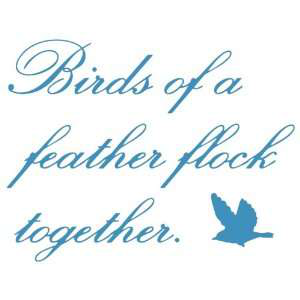

In [2]:
from PIL import Image
import urllib.request as url
import io

fd = url.urlopen("http://commentsmeme.com/wp-content/uploads/2014/02/Birds-Quotes-23.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

Organizing the world into objects with similar features and applying labels to them is second nature to humans.  An object with four legs that is brown may be labelled a horse.  A small object with four legs that is brown may be labelled a dog.  This action is a form of clustering.

Clustering has proven to be an extraordinarily valuable tool.  Two overwhelmingly successful examples:

1. The periodic table of elements in chemistry.
2. The standard model of particle physics.

Clustering based on observed characteristics can, however, also be misleading.  For example, genetically a cow is more silimar to a whale than it is to a horse.  

In a dataset, a cluster is a set of labels that are more similar to each other (with respect to their features) than to members of other clusters.  

We will implement a popular clustering algorithm, K-Means.

## K-Means Clustering

K-means clustering is a popular method to partition data into K distinct, mutually-exclusive clusters.  That is, each observation in a dataframe is assigned to $one$ and only $one$ cluster.  To perform K-means clustering, we must first specify the desired number of clusters, $K$, and the algorithm will assign each observation to a unique cluster number, $1,...,K$. 

A guiding principal behind K-means clustering is that a "good" set of clusters are those for which the within-cluster variation is as small as possible.  The within-cluster variation for cluster $C_k, k=1,...,K$, is a measure, $W(C_k)$, of the amount by which the observations within a cluster differ from each other.  

Formally, the algorithm:

${\displaystyle min_{C_1, ..., C_K} \sum_k W(C_k)}$ where the within variance is calculated using the Euclidian distance metric.

Recall that the Euclidian distance between to two points, $(x_{1j}$, $x_{2j})$ and $(x_{1k}$, $x_{2k})$, is $\sqrt{(x_{1j} - x_{2j})^2 + (x_{1k} - x_{2k})^2}$  The points can be in high dimensional space.

Algorithm

1. Randomly assigs a cluster number, $1,...,K$, to each of the $N$ observations in the dataframe, which serve as initial cluster assignments.
2. Compute a cluster "centroid" for each of the $K$ clusters.  The $k^{th}$ cluster centroid is a vector of the feature averages for the observations in the $k^{th}$ cluster.  
3. Assigns each observation to the cluster whose centroid is closest to it (in Euclidian distance).
4. Iterates the cluster assignments until they stop changing.

Some practical decisions with respect to cluster analysis:

1. Should the features ﬁrst be standardized in some way?  For instance, should the features be normalized to be mean zero and variance one?  
2. How many clusters should be used?

As with life, there is no free lunch.  There is no single "right" answer, and any solution that exposes interesting aspects of your data should be considered.  You might, for example, use training and test samples (if you have enough data) to examine how your decisions affect your results.

Let's conceptualize.

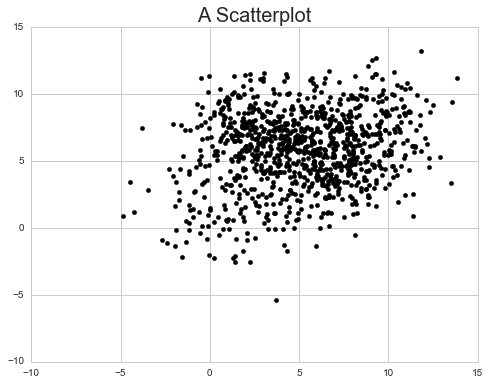

In [3]:
# Illustrate K-means clustering with synthetic data.
# Create four clusters and then add white noise.

np.random.seed(12345)
label = stats.binom.rvs(p = 0.5, n=3, size = 1000)
xc=np.array([1,7,3,9])
yc=np.array([1,5,7,9])
x=xc[np.array(label)] + stats.norm.rvs(0, 2, size = 1000)
y=yc[np.array(label)] + stats.norm.rvs(0, 2, size = 1000)
X=np.append(x, y).reshape(2, 1000).transpose()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c = 'black')
plt.title('A Scatterplot', fontsize = 20)

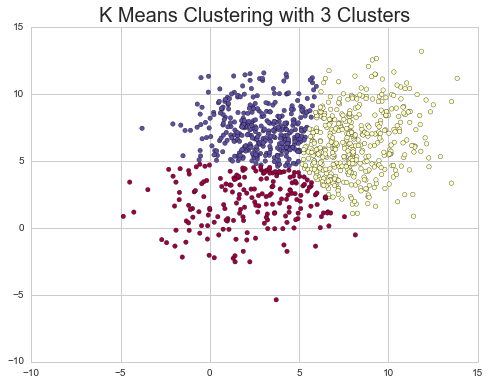

In [4]:
# Import KMeans from sklearn
# Import shapefile (pip install pyshp)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Start with two clusters and then increase.
k = 3

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.float) 
cmap = get_cmap("Spectral")

plt.figure(figsize = (8, 6))
plt.scatter(x, y, c = colors, cmap = cmap)
plt.title("K Means Clustering with %i Clusters" % (k), fontsize = 20)

### How Many Clusters?

To answer this question, we turn to the "Silhouette Score", called $S$, which is a measure of within-cluster similarity.

By construction, $S$ is bounded between -1 and 1, where 1 means that all within-cluster observations coinside perfectly with their cluster centroids.  This is equivalent to saying that there is zero with-in cluster variance for all clusters.  

Positive values of $S$ indicate that within-cluster observations are closer to their cluster centroids than they are to other cluster centroids.  

Values of $S$ near zero indicate that clustering is either inappropriate or unstable (that is, an alternative arrangement of the data into the same number of clusters would not decrease within-cluster variance). 

Typically, once you have invoked the k-means clustering algorithm, $S$ will be positive.

At 2 clusters, silhouette score is 0.36437314936647613
At 3 clusters, silhouette score is 0.3733728570798334
At 4 clusters, silhouette score is 0.3770798404138101
At 5 clusters, silhouette score is 0.334411463832445
At 6 clusters, silhouette score is 0.3297028291823592
At 7 clusters, silhouette score is 0.3259656755038059
At 8 clusters, silhouette score is 0.3310849349903425
At 9 clusters, silhouette score is 0.328875175343867


(0.2, 0.4)

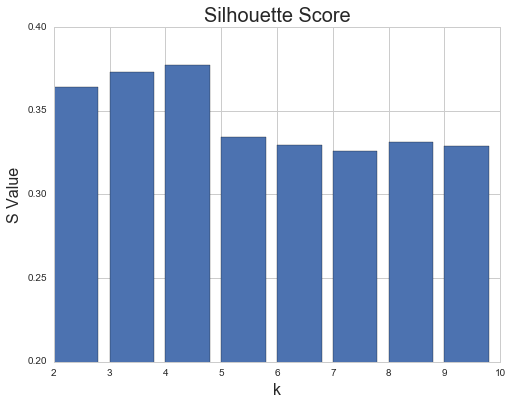

In [5]:
# Calculate S to evaluate the performance of clustering at different values of k.

s = np.zeros(8)
for k in range(0, 8):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(X)
    s[k] = silhouette_score(X, est.labels_)
    print('At {0} clusters, silhouette score is {1}'.format(k+2, s[k]))
    
plt.figure(figsize=(8, 6))
plt.bar(range(2, 10), s)
plt.xlabel('k', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20)
plt.ylim(.2, .4)

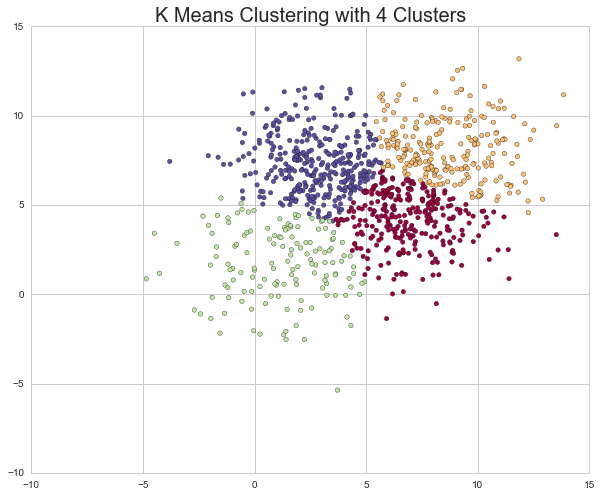

In [6]:
kopt = 4
kmeans = KMeans(n_clusters = kopt, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.int) 
cmap = get_cmap("Spectral")

plt.figure(figsize = (10,8))
plt.scatter(x, y, c = colors , cmap = cmap)
plt.title("K Means Clustering with %i Clusters" % (kopt), fontsize = 20)

### Application: Census Tracts in Massachusetts

In [7]:
# Grab Census data on all tracts in Mass and create population and housing density as features.

url = 'http://www2.census.gov/geo/docs/maps-data/data/gazetteer/census_tracts_list_25.txt'
names = ['geo', 'pop', 'hu', 'land', 'water', 'landSqmi', 'waterSqmi', 'lat', 'long']
data = pd.read_table(url, header = 0, names = names)

data['popDensity'] = data['pop'] / data['landSqmi']
data['houseDensity'] = data['hu'] / data['landSqmi']

data = data.dropna()

In [8]:
data.describe()

,geo,pop,hu,land,water,landSqmi,waterSqmi,lat,long,popDensity,houseDensity
count,1.471000e+03,1471.000000,1471.000000,1.471000e+03,1.471000e+03,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,2.501717e+10,4451.141400,1909.078178,1.373355e+07,1.184636e+06,5.302558,0.457389,42.268365,-71.365251,7267.976995,3245.475591
std,7.785589e+06,1678.802425,732.395461,3.047695e+07,5.397417e+06,11.767217,2.083953,0.285613,0.631055,10641.463093,5461.474612
min,2.500101e+10,0.000000,0.000000,4.338100e+04,0.000000e+00,0.017000,0.000000,41.256040,-73.449262,0.000000,0.000000
25%,2.500926e+10,3226.000000,1389.500000,1.021472e+06,6.460000e+03,0.394000,0.002000,42.123141,-71.572898,833.845345,357.903487
50%,2.501735e+10,4320.000000,1854.000000,3.826401e+06,1.435230e+05,1.477000,0.055000,42.313847,-71.142477,3120.263591,1266.311585
75%,2.502500e+10,5588.000000,2412.000000,1.419304e+07,6.762270e+05,5.480000,0.261000,42.443972,-71.027253,9425.343175,3989.524152
max,2.502776e+10,12079.000000,5220.000000,5.034679e+08,1.451590e+08,194.390000,56.046000,42.862710,-69.952894,109754.716981,61058.823529


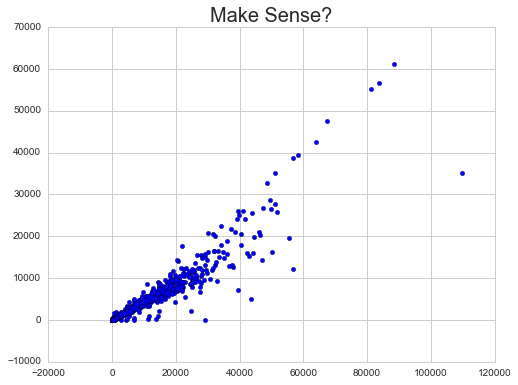

In [9]:
plt.figure(figsize =(8, 6))
plt.scatter(data['popDensity'], data['houseDensity'], c = 'blue')
plt.title('Make Sense?', fontsize = 20)

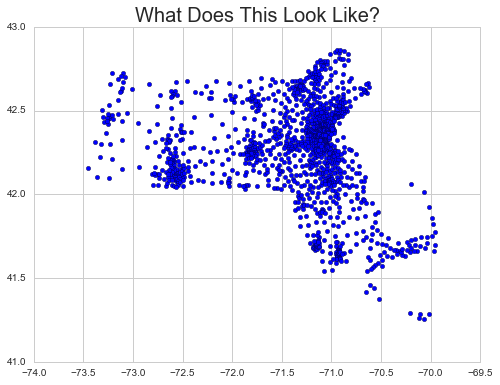

In [10]:
plt.figure(figsize = (8, 6))
plt.scatter(data['long'], data['lat'], c = 'blue')
plt.title('What Does This Look Like?', fontsize = 20)

In [11]:
# Now this is clunky because we need to move out of DataFrame into numpy matrix

X = data[['popDensity', 'houseDensity']].as_matrix(columns = None)
X.shape

(1471, 2)

In [19]:
# Use k means with 10 predetermined clusters.

k = 10

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.int) 
cmap = get_cmap("Spectral")

In [17]:
colors.shape
data['cluster'] = colors
data.head()

,geo,pop,hu,land,water,landSqmi,waterSqmi,lat,long,popDensity,houseDensity,cluster
MA,25001010100,2942,4494,25047886,12766243,9.671,4.929,42.059829,-70.200407,304.208458,464.688243,0
MA,25001010206,2750,4305,51262713,18830104,19.793,7.270,41.922562,-70.015406,138.938008,217.501137,0
MA,25001010208,2003,3077,54274481,11453822,20.955,4.422,42.013558,-70.064152,95.585779,146.838463,0
MA,25001010304,2421,2706,18346123,7829570,7.083,3.023,41.823754,-69.977249,341.804320,382.041508,0
MA,25001010306,2535,3254,17806319,1730602,6.875,0.668,41.859334,-69.982678,368.727273,473.309091,0


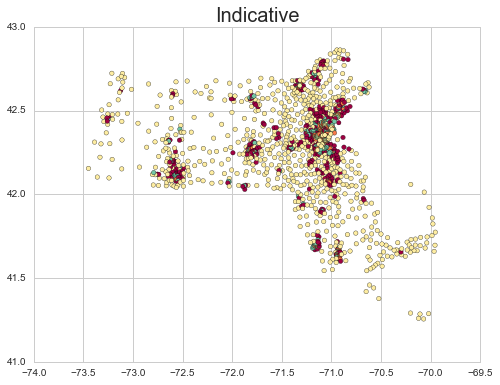

In [20]:
# Now graph clusters
plt.figure(figsize=(8, 6))
plt.scatter(data['long'], data['lat'], c = colors, cmap = cmap)
plt.title('Indicative', fontsize = 20)